✅ Import thư viện thành công!

⏳ Đang tải dữ liệu từ c:\GitProjects\air_quality_timeseries-lab4\data\raw\PRSA2017_Data_20130301-20170228.zip...
✅ Dữ liệu đã được làm sạch.

🤖 [1/2] Đang chạy mô hình ARIMA...
   - Đang fit ARIMA(2,0,1)...


c:\GitProjects\air_quality_timeseries-lab4\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


✅ ARIMA hoàn tất.

🤖 [2/2] Đang chạy Regression Baseline...
   - Features sử dụng: ['No', 'year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM2.5_lag1', 'PM2.5_lag2', 'PM2.5_lag3', 'PM2.5_lag24']
✅ Regression hoàn tất.

📊 Đang tổng hợp và vẽ 3 biểu đồ so sánh...


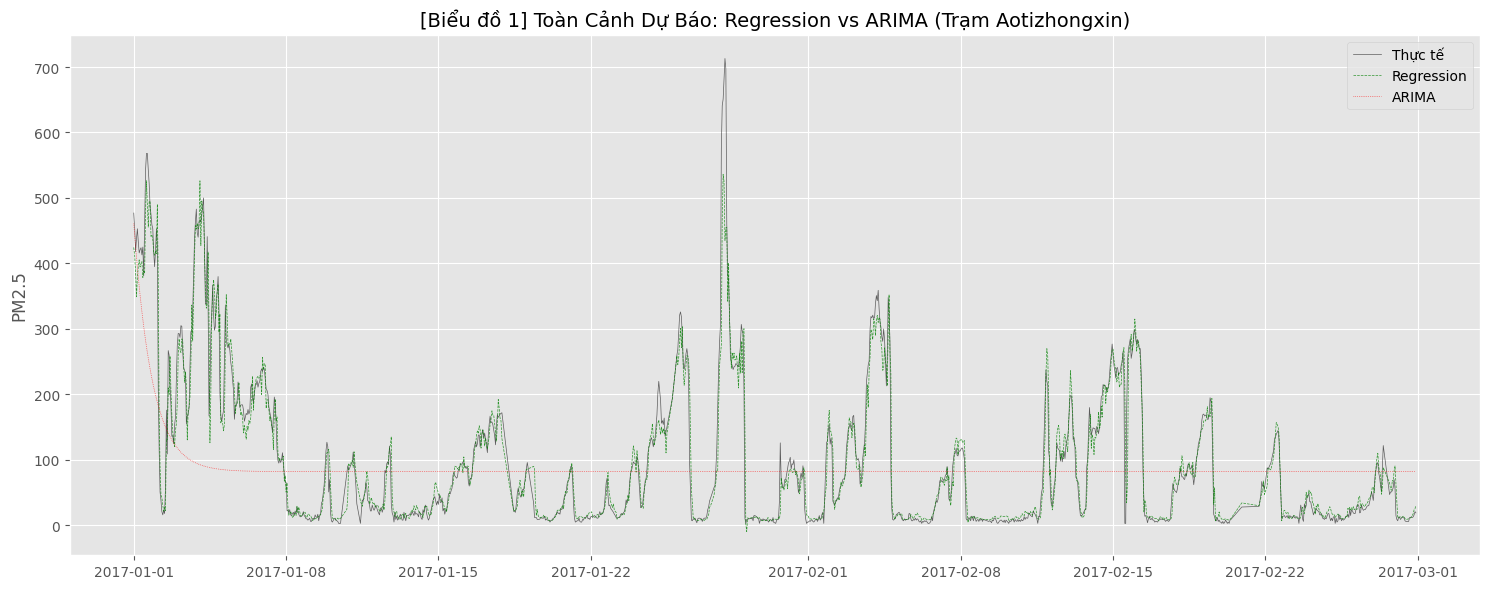

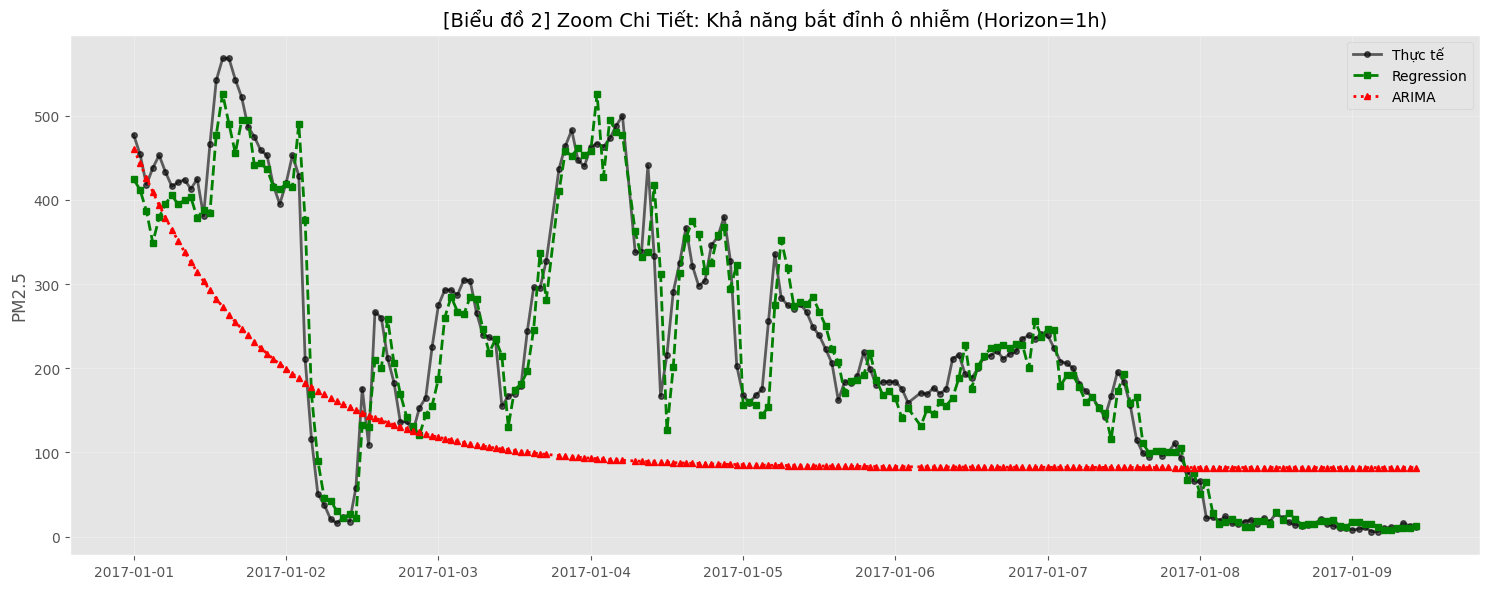

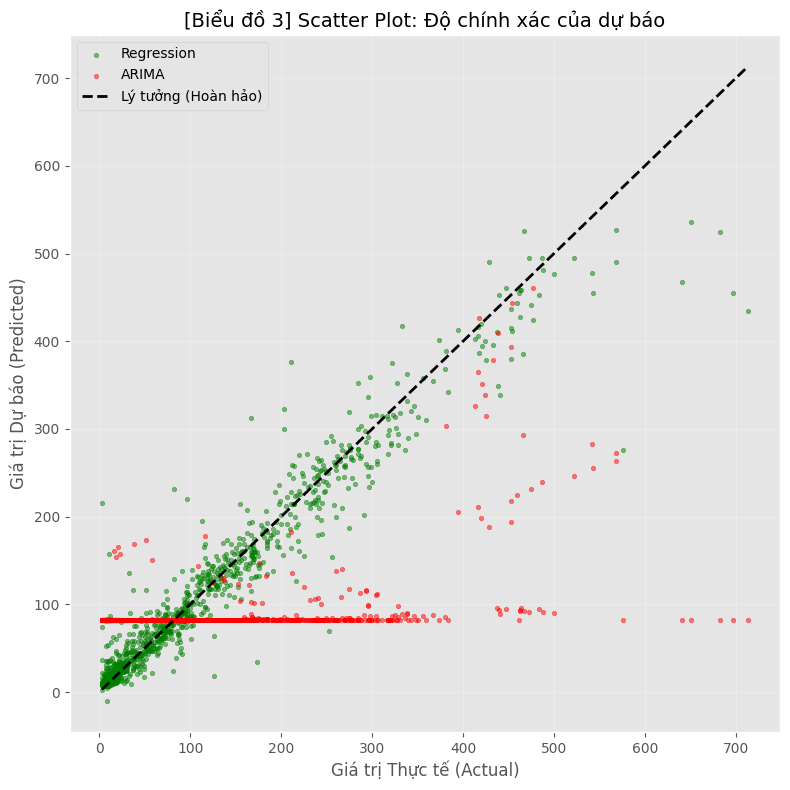

--------------------------------------------------
🏆 KẾT QUẢ ĐÁNH GIÁ (Horizon = 1 giờ):
➤ Regression   | RMSE: 28.33 | MAE: 14.54
➤ ARIMA        | RMSE: 106.29 | MAE: 79.41
--------------------------------------------------


In [10]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import HistGradientBoostingRegressor

# ==============================================================================
# 1. CẤU HÌNH HỆ THỐNG & IMPORT
# ==============================================================================
# Tự động tìm thư mục gốc để import được 'src'
current_dir = Path.cwd()
project_root = None

if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
elif (current_dir.parent.parent / 'src').exists():
    project_root = current_dir.parent.parent
else:
    project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"✅ Đã thêm đường dẫn project: {project_root}")

# Import các hàm từ thư viện dự án
try:
    from src.classification_library import load_beijing_air_quality, clean_air_quality_df, add_time_features
    from src.timeseries_library import StationSeriesConfig, make_hourly_station_series, train_test_split_series
    from src.regression_library import add_lag_features_for_regression
    print("✅ Import thư viện thành công!")
except ImportError as e:
    print("❌ LỖI: Không tìm thấy thư mục 'src'. Hãy đảm bảo file này nằm trong thư mục dự án.")
    raise e

# ==============================================================================
# 2. CẤU HÌNH THAM SỐ THÍ NGHIỆM
# ==============================================================================
STATION = 'Aotizhongxin'       # Trạm muốn dự báo
CUTOFF = '2017-01-01'          # Ngày chia Train/Test
HORIZON = 1                    # Dự báo 1 giờ tới (Short-term)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

# Tìm file dữ liệu
full_zip_path = next((str(p) for p in [
    project_root / RAW_ZIP_PATH, 
    Path(RAW_ZIP_PATH)
] if Path(p).exists()), None)

if not full_zip_path:
    raise FileNotFoundError(f"❌ Không tìm thấy file dữ liệu tại: {RAW_ZIP_PATH}")

# ==============================================================================
# 3. TẢI VÀ LÀM SẠCH DỮ LIỆU
# ==============================================================================
print(f"\n⏳ Đang tải dữ liệu từ {full_zip_path}...")
df_raw = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=full_zip_path)
df_clean = clean_air_quality_df(df_raw)
print("✅ Dữ liệu đã được làm sạch.")

# ==============================================================================
# 4. MÔ HÌNH 1: ARIMA (Time Series thuần túy)
# ==============================================================================
print("\n🤖 [1/2] Đang chạy mô hình ARIMA...")

# Tạo chuỗi thời gian đơn biến
cfg = StationSeriesConfig(station=STATION, value_col='PM2.5', freq='H')
ts_series = make_hourly_station_series(df_clean, cfg)

# Chia Train/Test
train_ts, test_ts = train_test_split_series(ts_series, cutoff=CUTOFF)

# Huấn luyện (Dùng Order (2,0,1) làm ví dụ, bạn có thể thay bằng Best Order của nhóm)
print("   - Đang fit ARIMA(2,0,1)...")
arima_model = ARIMA(train_ts, order=(2, 0, 1)) 
arima_fit = arima_model.fit()

# Dự báo (One-step-ahead prediction trên tập test)
# Predict sẽ trả về giá trị dự báo cho từng điểm thời gian trong index của test_ts
arima_pred_values = arima_fit.predict(start=test_ts.index[0], end=test_ts.index[-1])

# Đảm bảo index khớp
arima_series = pd.Series(arima_pred_values, index=test_ts.index, name='ARIMA')
print("✅ ARIMA hoàn tất.")

# ==============================================================================
# 5. MÔ HÌNH 2: REGRESSION BASELINE (Hồi quy có giám sát)
# ==============================================================================
print("\n🤖 [2/2] Đang chạy Regression Baseline...")

# Lọc dữ liệu trạm và thêm đặc trưng thời gian
df_reg = df_clean[df_clean['station'] == STATION].copy()
df_reg = add_time_features(df_reg)

# Thêm đặc trưng độ trễ (Lags) - Yếu tố quan trọng nhất
# Lag 1: Giờ trước, Lag 24: Giờ này hôm qua
df_reg = add_lag_features_for_regression(df_reg, lag_hours=[1, 2, 3, 24], cols=['PM2.5'])

# Tạo biến mục tiêu (Target): PM2.5 của tương lai (Shift ngược)
df_reg['target'] = df_reg['PM2.5'].shift(-HORIZON)

# Loại bỏ các dòng thiếu dữ liệu (do tạo lag và shift)
df_reg = df_reg.dropna()

# Chia Train/Test theo thời gian
train_reg = df_reg[df_reg['datetime'] < CUTOFF]
test_reg = df_reg[df_reg['datetime'] >= CUTOFF]

# --- QUAN TRỌNG: LỌC CỘT SỐ (FIX LỖI STRING) ---
# Chỉ lấy các cột số, loại bỏ cột 'wd' (hướng gió - dạng chữ) gây lỗi
numeric_cols = train_reg.select_dtypes(include=[np.number]).columns.tolist()
# Loại bỏ target và cột PM2.5 gốc (để tránh data leakage, chỉ dùng Lags)
features = [c for c in numeric_cols if c not in ['target', 'PM2.5']]

print(f"   - Features sử dụng: {features}")

X_train, y_train = train_reg[features], train_reg['target']
X_test, y_test = test_reg[features], test_reg['target']

# Huấn luyện mô hình HistGradientBoosting (Mạnh mẽ, xử lý tốt NaN nếu còn sót)
reg_model = HistGradientBoostingRegressor(random_state=42)
reg_model.fit(X_train, y_train)
reg_pred = reg_model.predict(X_test)
print("✅ Regression hoàn tất.")

# ==============================================================================
# 6. TỔNG HỢP KẾT QUẢ VÀ VẼ 3 BIỂU ĐỒ (CẬP NHẬT)
# ==============================================================================
print("\n📊 Đang tổng hợp và vẽ 3 biểu đồ so sánh...")

# 1. Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    'datetime': test_reg['datetime'],
    'Actual': y_test,
    'Regression': reg_pred
}).set_index('datetime')

# Join ARIMA vào
comparison_df = comparison_df.join(arima_series, how='inner')

# ------------------------------------------------------------------------------
# BIỂU ĐỒ 1: TOÀN CẢNH (OVERVIEW)
# Mục đích: Thấy hiệu suất chung trên toàn bộ giai đoạn test
# ------------------------------------------------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'k-', label='Thực tế', linewidth=0.5, alpha=0.6)
plt.plot(comparison_df.index, comparison_df['Regression'], 'g--', label='Regression', linewidth=0.5, alpha=0.8)
if 'ARIMA' in comparison_df.columns:
    plt.plot(comparison_df.index, comparison_df['ARIMA'], 'r:', label='ARIMA', linewidth=0.5, alpha=0.8)

plt.title(f'[Biểu đồ 1] Toàn Cảnh Dự Báo: Regression vs ARIMA (Trạm {STATION})', fontsize=14)
plt.ylabel('PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# BIỂU ĐỒ 2: ZOOM CHI TIẾT (200 GIỜ ĐẦU)
# Mục đích: Soi khả năng bắt đỉnh (Spike) và độ trễ (Lag)
# ------------------------------------------------------------------------------
plt.figure(figsize=(15, 6))
# Lấy 200 giờ đầu tiên (khoảng 1 tuần rưỡi)
zoom_df = comparison_df.iloc[:200]

plt.plot(zoom_df.index, zoom_df['Actual'], 'k-o', label='Thực tế', linewidth=2, markersize=4, alpha=0.6)
plt.plot(zoom_df.index, zoom_df['Regression'], 'g--s', label='Regression', linewidth=2, markersize=4)
if 'ARIMA' in zoom_df.columns:
    plt.plot(zoom_df.index, zoom_df['ARIMA'], 'r:^', label='ARIMA', linewidth=2, markersize=4)

plt.title(f'[Biểu đồ 2] Zoom Chi Tiết: Khả năng bắt đỉnh ô nhiễm (Horizon={HORIZON}h)', fontsize=14)
plt.ylabel('PM2.5')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# BIỂU ĐỒ 3: SCATTER PLOT (DỰ BÁO VS THỰC TẾ)
# Mục đích: Đánh giá độ chụm. Càng bám sát đường chéo màu đỏ càng tốt.
# ------------------------------------------------------------------------------
plt.figure(figsize=(8, 8))

# Vẽ Regression
plt.scatter(comparison_df['Actual'], comparison_df['Regression'], 
            alpha=0.5, color='green', s=10, label=f'Regression')

# Vẽ ARIMA
if 'ARIMA' in comparison_df.columns:
    plt.scatter(comparison_df['Actual'], comparison_df['ARIMA'], 
                alpha=0.5, color='red', s=10, label=f'ARIMA')

# Vẽ đường lý tưởng y = x
min_val = comparison_df['Actual'].min()
max_val = comparison_df['Actual'].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Lý tưởng (Hoàn hảo)')

plt.title('[Biểu đồ 3] Scatter Plot: Độ chính xác của dự báo', fontsize=14)
plt.xlabel('Giá trị Thực tế (Actual)')
plt.ylabel('Giá trị Dự báo (Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In Metrics cuối cùng
print("-" * 50)
print(f"🏆 KẾT QUẢ ĐÁNH GIÁ (Horizon = {HORIZON} giờ):")
for model_name in ['Regression', 'ARIMA']:
    if model_name in comparison_df.columns:
        rmse = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df[model_name]))
        mae = mean_absolute_error(comparison_df['Actual'], comparison_df[model_name])
        print(f"➤ {model_name:<12} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")
print("-" * 50)

✅ Import thư viện thành công!
⏳ Đang tải và xử lý dữ liệu cho trạm Aotizhongxin...


c:\GitProjects\air_quality_timeseries-lab4\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


✅ Dữ liệu sẵn sàng.


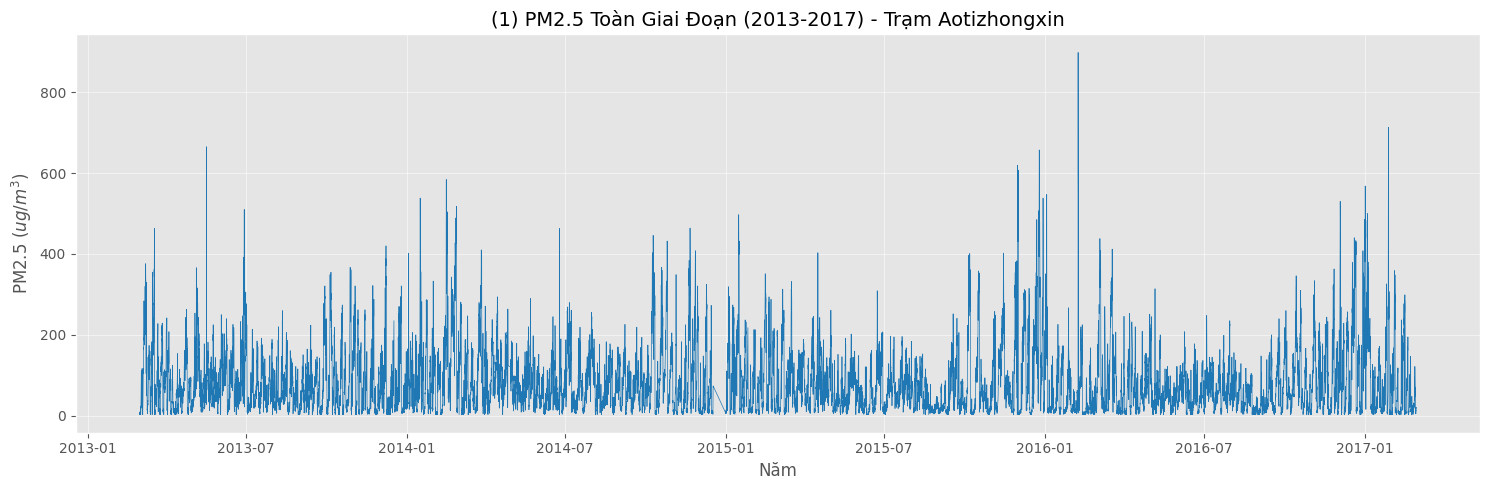

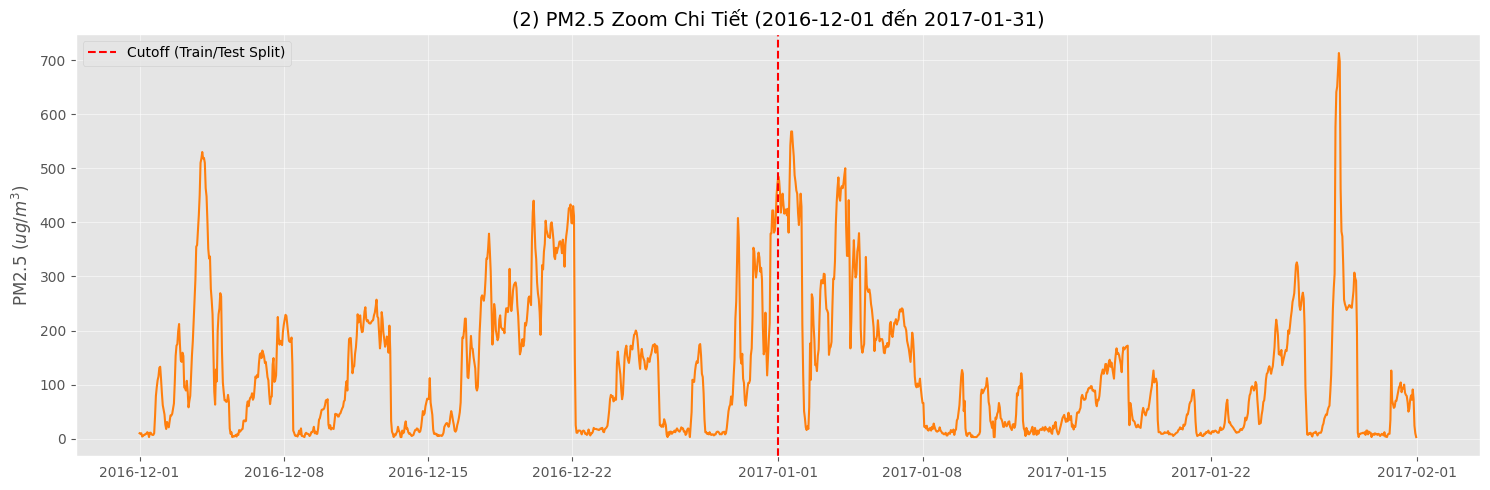

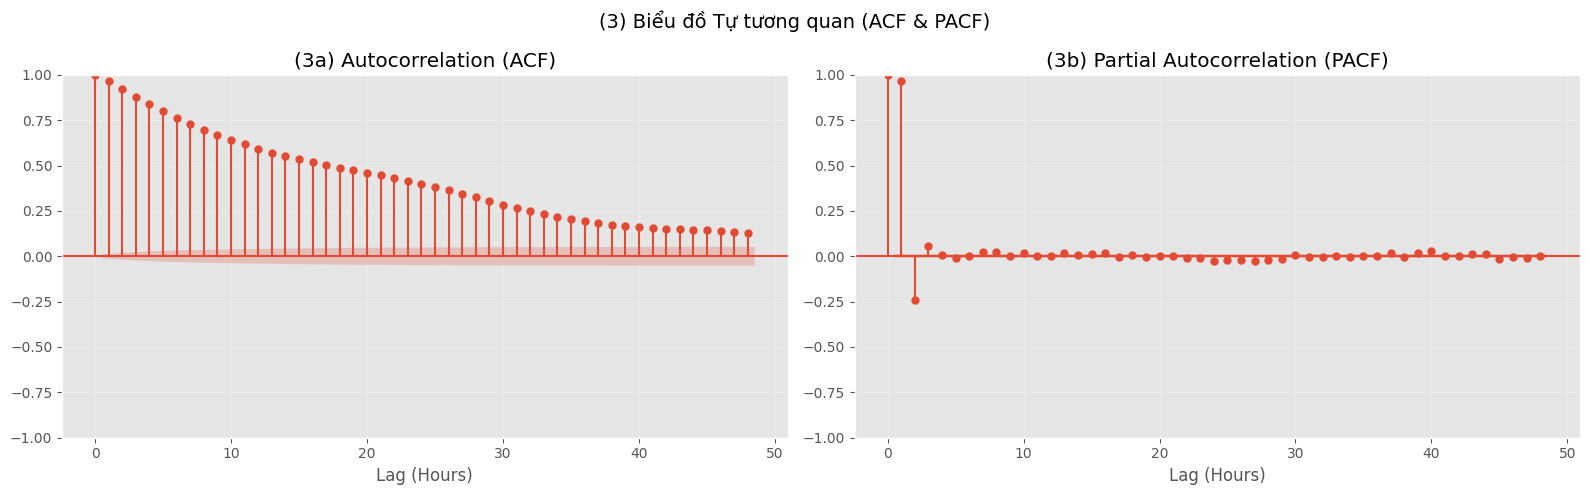

⏳ Đang huấn luyện ARIMA để vẽ hình dự báo (Chờ xíu nhé)...


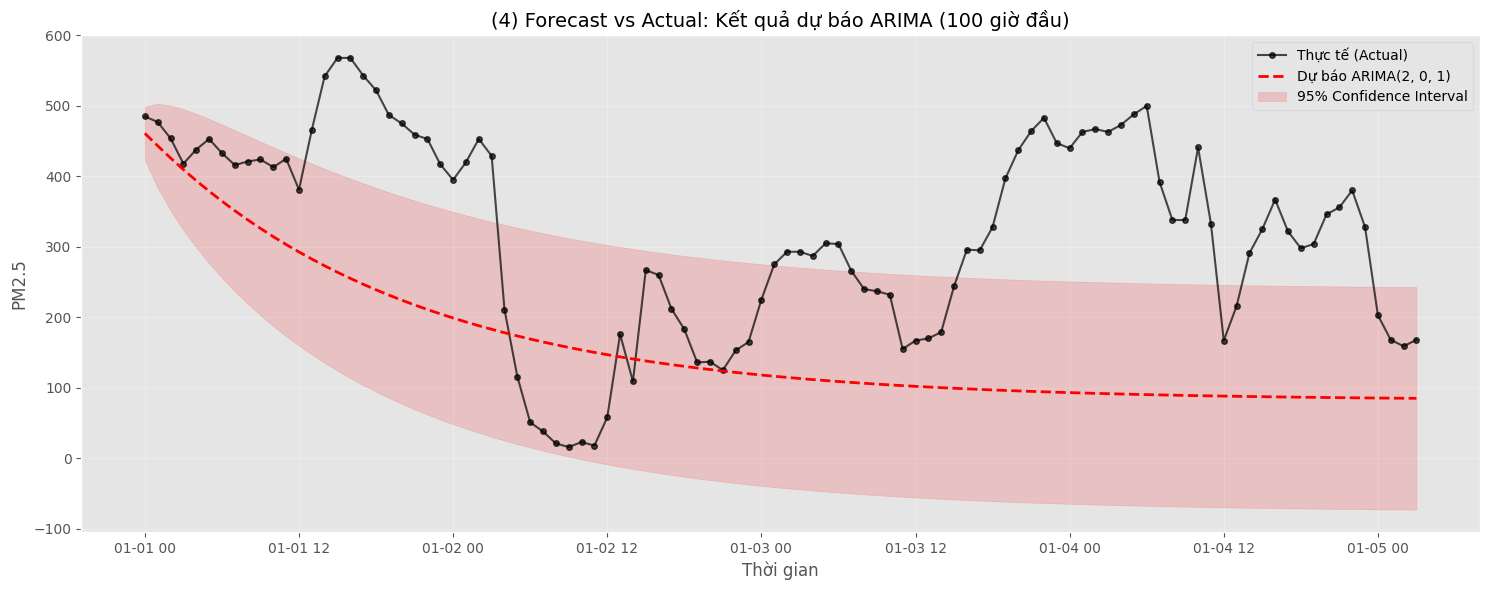

✅ Đã vẽ xong toàn bộ 4 hình!


In [11]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ==============================================================================
# 1. CẤU HÌNH & IMPORT (Tự động tìm thư mục src)
# ==============================================================================
current_dir = Path.cwd()
project_root = None

if (current_dir / 'src').exists(): project_root = current_dir
elif (current_dir.parent / 'src').exists(): project_root = current_dir.parent
elif (current_dir.parent.parent / 'src').exists(): project_root = current_dir.parent.parent
else: project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

try:
    from src.classification_library import load_beijing_air_quality, clean_air_quality_df
    from src.timeseries_library import StationSeriesConfig, make_hourly_station_series, train_test_split_series
    print("✅ Import thư viện thành công!")
except ImportError:
    print("❌ Lỗi: Không tìm thấy thư mục 'src'. Đảm bảo file notebook nằm trong dự án.")

# ==============================================================================
# 2. CHUẨN BỊ DỮ LIỆU
# ==============================================================================
STATION = 'Aotizhongxin'       # Trạm cần vẽ
CUTOFF = '2017-01-01'          # Mốc chia Train/Test
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

# Tìm file data
full_zip_path = next((str(p) for p in [project_root / RAW_ZIP_PATH, Path(RAW_ZIP_PATH)] if Path(p).exists()), None)
if not full_zip_path: raise FileNotFoundError(f"Không tìm thấy file zip tại {RAW_ZIP_PATH}")

print(f"⏳ Đang tải và xử lý dữ liệu cho trạm {STATION}...")
df_raw = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=full_zip_path)
df_clean = clean_air_quality_df(df_raw)

# Tạo chuỗi thời gian (Time Series)
cfg = StationSeriesConfig(station=STATION, value_col='PM2.5', freq='H')
ts = make_hourly_station_series(df_clean, cfg)
train, test = train_test_split_series(ts, cutoff=CUTOFF)
print("✅ Dữ liệu sẵn sàng.")

# Thiết lập style cho biểu đồ đẹp hơn
plt.style.use('ggplot')

# ==============================================================================
# HÌNH 1: PM2.5 TOÀN GIAI ĐOẠN (Overview)
# ==============================================================================
plt.figure(figsize=(15, 5))
plt.plot(ts.index, ts.values, color='#1f77b4', linewidth=0.5)
plt.title(f'(1) PM2.5 Toàn Giai Đoạn (2013-2017) - Trạm {STATION}', fontsize=14)
plt.ylabel('PM2.5 ($ug/m^3$)')
plt.xlabel('Năm')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# ==============================================================================
# HÌNH 2: PM2.5 ZOOM 1-2 THÁNG (Chi tiết)
# ==============================================================================
# Chọn khoảng thời gian có biến động rõ (Ví dụ: Tháng 12/2016 đến hết tháng 1/2017)
zoom_start = '2016-12-01'
zoom_end = '2017-01-31'
ts_zoom = ts[zoom_start:zoom_end]

plt.figure(figsize=(15, 5))
plt.plot(ts_zoom.index, ts_zoom.values, color='#ff7f0e', linewidth=1.5)
# Đánh dấu mốc Cutoff nếu nằm trong vùng zoom
if pd.Timestamp(CUTOFF) >= pd.Timestamp(zoom_start) and pd.Timestamp(CUTOFF) <= pd.Timestamp(zoom_end):
    plt.axvline(pd.Timestamp(CUTOFF), color='red', linestyle='--', label='Cutoff (Train/Test Split)')
    plt.legend()

plt.title(f'(2) PM2.5 Zoom Chi Tiết ({zoom_start} đến {zoom_end})', fontsize=14)
plt.ylabel('PM2.5 ($ug/m^3$)')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# ==============================================================================
# HÌNH 3: ACF & PACF (Kiểm tra tự tương quan)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Vẽ ACF (Autocorrelation)
plot_acf(train.dropna(), lags=48, ax=axes[0], alpha=0.05, title='(3a) Autocorrelation (ACF)')
axes[0].set_xlabel('Lag (Hours)')
axes[0].grid(True, alpha=0.3)

# Vẽ PACF (Partial Autocorrelation)
plot_pacf(train.dropna(), lags=48, ax=axes[1], alpha=0.05, title='(3b) Partial Autocorrelation (PACF)')
axes[1].set_xlabel('Lag (Hours)')
axes[1].grid(True, alpha=0.3)

plt.suptitle('(3) Biểu đồ Tự tương quan (ACF & PACF)', fontsize=14)
plt.tight_layout()
plt.show()

# ==============================================================================
# HÌNH 4: FORECAST VS ACTUAL (ARIMA)
# ==============================================================================
print("⏳ Đang huấn luyện ARIMA để vẽ hình dự báo (Chờ xíu nhé)...")

# Huấn luyện mô hình ARIMA đơn giản (Ví dụ: p=2, d=0, q=1)
# Bạn có thể thay đổi order theo kết quả Grid Search tốt nhất của nhóm
my_order = (2, 0, 1) 
model = ARIMA(train, order=my_order)
model_fit = model.fit()

# Dự báo trên tập Test (Lấy 100 giờ đầu để nhìn cho rõ)
test_sample = test.iloc[:100]
forecast_res = model_fit.get_forecast(steps=len(test_sample))
pred_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

plt.figure(figsize=(15, 6))
# Vẽ dữ liệu thực tế
plt.plot(test_sample.index, test_sample.values, label='Thực tế (Actual)', color='black', marker='o', markersize=4, alpha=0.7)
# Vẽ dự báo
plt.plot(pred_mean.index, pred_mean.values, label=f'Dự báo ARIMA{my_order}', color='red', linestyle='--', linewidth=2)
# Vẽ khoảng tin cậy 95%
plt.fill_between(pred_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.15, label='95% Confidence Interval')

plt.title(f'(4) Forecast vs Actual: Kết quả dự báo ARIMA (100 giờ đầu)', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Đã vẽ xong toàn bộ 4 hình!")

✅ Import thư viện thành công!
⏳ Đang tải dữ liệu cho trạm Aotizhongxin...

🤖 [1/2] Đang chạy ARIMA...


c:\GitProjects\air_quality_timeseries-lab4\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


🤖 [2/2] Đang chạy Regression Baseline...

🏆 KẾT QUẢ SO SÁNH (Horizon = 1 giờ):
--------------------------------------------------
➤ Regression   | RMSE: 28.33 | MAE: 14.54
➤ ARIMA        | RMSE: 106.29 | MAE: 79.41
--------------------------------------------------


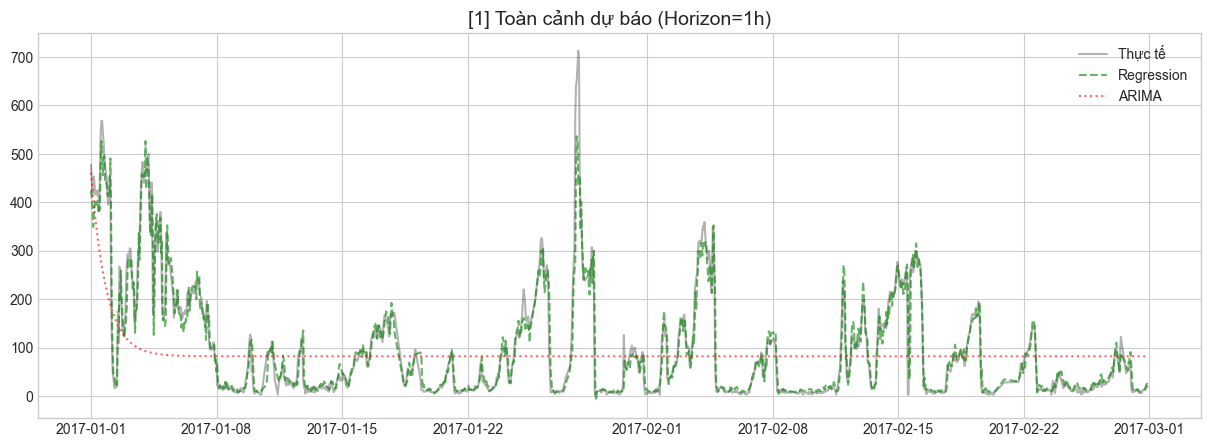

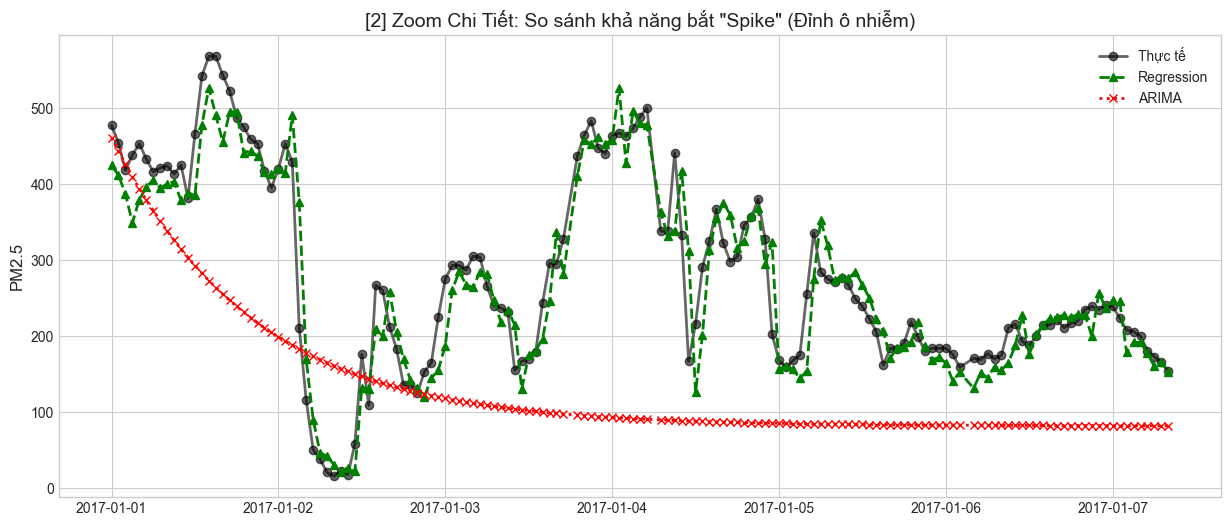

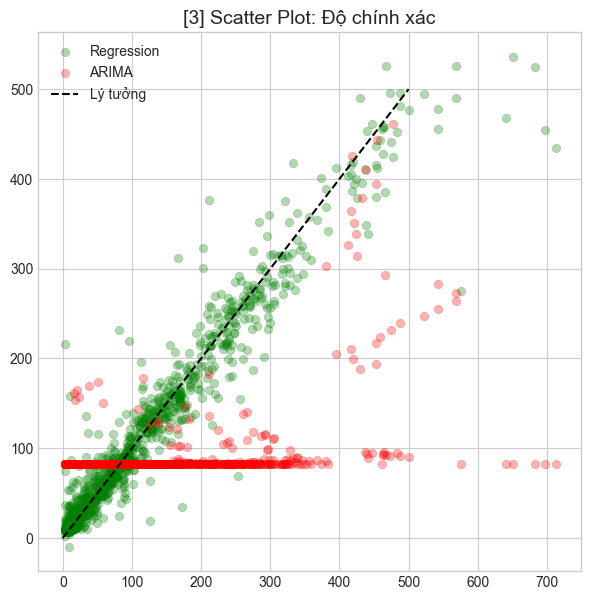

In [12]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import HistGradientBoostingRegressor

# ==============================================================================
# 1. CẤU HÌNH & IMPORT
# ==============================================================================
current_dir = Path.cwd()
project_root = None
if (current_dir / 'src').exists(): project_root = current_dir
elif (current_dir.parent / 'src').exists(): project_root = current_dir.parent
elif (current_dir.parent.parent / 'src').exists(): project_root = current_dir.parent.parent
else: project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

try:
    from src.classification_library import load_beijing_air_quality, clean_air_quality_df, add_time_features
    from src.timeseries_library import StationSeriesConfig, make_hourly_station_series, train_test_split_series
    from src.regression_library import add_lag_features_for_regression
    print("✅ Import thư viện thành công!")
except ImportError:
    print("❌ Lỗi: Không tìm thấy thư mục 'src'.")

# ==============================================================================
# 2. THIẾT LẬP THÍ NGHIỆM
# ==============================================================================
STATION = 'Aotizhongxin'
CUTOFF = '2017-01-01'
HORIZON = 1  # Dự báo 1 giờ tới (Short-term)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

# Tìm file data
full_zip_path = next((str(p) for p in [project_root / RAW_ZIP_PATH, Path(RAW_ZIP_PATH)] if Path(p).exists()), None)
if not full_zip_path: raise FileNotFoundError(f"Không tìm thấy file zip tại {RAW_ZIP_PATH}")

print(f"⏳ Đang tải dữ liệu cho trạm {STATION}...")
df_raw = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=full_zip_path)
df_clean = clean_air_quality_df(df_raw)

# ==============================================================================
# 3. MÔ HÌNH 1: ARIMA (Time Series thuần túy)
# ==============================================================================
print("\n🤖 [1/2] Đang chạy ARIMA...")
cfg = StationSeriesConfig(station=STATION, value_col='PM2.5', freq='H')
ts_series = make_hourly_station_series(df_clean, cfg)
train_ts, test_ts = train_test_split_series(ts_series, cutoff=CUTOFF)

# Fit ARIMA (Ví dụ order 2,0,1 - Nhóm bạn có thể thay bằng kết quả Grid Search)
arima_model = ARIMA(train_ts, order=(2, 0, 1)) 
arima_fit = arima_model.fit()
# Dự báo One-step-ahead cho toàn bộ tập test
arima_pred_values = arima_fit.predict(start=test_ts.index[0], end=test_ts.index[-1])
arima_series = pd.Series(arima_pred_values, index=test_ts.index, name='ARIMA')

# ==============================================================================
# 4. MÔ HÌNH 2: REGRESSION BASELINE (Hồi quy)
# ==============================================================================
print("🤖 [2/2] Đang chạy Regression Baseline...")
df_reg = df_clean[df_clean['station'] == STATION].copy()
df_reg = add_time_features(df_reg)
# Tạo Lags: Đây là vũ khí của Regression (Lag 1 cực quan trọng cho Horizon=1)
df_reg = add_lag_features_for_regression(df_reg, lag_hours=[1, 2, 3, 24], cols=['PM2.5'])
# Tạo Target
df_reg['target'] = df_reg['PM2.5'].shift(-HORIZON)
df_reg = df_reg.dropna()

train_reg = df_reg[df_reg['datetime'] < CUTOFF]
test_reg = df_reg[df_reg['datetime'] >= CUTOFF]

# --- QUAN TRỌNG: CHỈ LẤY CỘT SỐ ---
numeric_cols = train_reg.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c not in ['target', 'PM2.5']]

X_train, y_train = train_reg[features], train_reg['target']
X_test, y_test = test_reg[features], test_reg['target']

reg_model = HistGradientBoostingRegressor(random_state=42)
reg_model.fit(X_train, y_train)
reg_pred = reg_model.predict(X_test)

# ==============================================================================
# 5. TỔNG HỢP & VẼ BIỂU ĐỒ SO SÁNH
# ==============================================================================
# Tạo DataFrame so sánh MỚI
comparison_df = pd.DataFrame({
    'datetime': test_reg['datetime'],
    'Actual': y_test,
    'Regression': reg_pred
}).set_index('datetime')
comparison_df = comparison_df.join(arima_series, how='inner')

# In Metrics
print(f"\n🏆 KẾT QUẢ SO SÁNH (Horizon = {HORIZON} giờ):")
print("-" * 50)
for model_name in ['Regression', 'ARIMA']:
    if model_name in comparison_df.columns:
        rmse = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df[model_name]))
        mae = mean_absolute_error(comparison_df['Actual'], comparison_df[model_name])
        print(f"➤ {model_name:<12} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")
print("-" * 50)

# VẼ 3 BIỂU ĐỒ
plt.style.use('seaborn-v0_8-whitegrid')

# Hình 1: Overview
plt.figure(figsize=(15, 5))
plt.plot(comparison_df.index, comparison_df['Actual'], 'k-', alpha=0.3, label='Thực tế')
plt.plot(comparison_df.index, comparison_df['Regression'], 'g--', alpha=0.6, label='Regression')
plt.plot(comparison_df.index, comparison_df['ARIMA'], 'r:', alpha=0.6, label='ARIMA')
plt.title(f'[1] Toàn cảnh dự báo (Horizon={HORIZON}h)', fontsize=14)
plt.legend()
plt.show()

# Hình 2: Zoom (Quan trọng nhất cho Chủ đề 1)
zoom_df = comparison_df.iloc[:150] # 150 giờ đầu
plt.figure(figsize=(15, 6))
plt.plot(zoom_df.index, zoom_df['Actual'], 'k-o', linewidth=2, label='Thực tế', alpha=0.6)
plt.plot(zoom_df.index, zoom_df['Regression'], 'g--^', linewidth=2, label='Regression')
plt.plot(zoom_df.index, zoom_df['ARIMA'], 'r:x', linewidth=2, label='ARIMA')
plt.title(f'[2] Zoom Chi Tiết: So sánh khả năng bắt "Spike" (Đỉnh ô nhiễm)', fontsize=14)
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Hình 3: Scatter
plt.figure(figsize=(7, 7))
plt.scatter(comparison_df['Actual'], comparison_df['Regression'], alpha=0.3, color='green', label='Regression')
plt.scatter(comparison_df['Actual'], comparison_df['ARIMA'], alpha=0.3, color='red', label='ARIMA')
plt.plot([0, 500], [0, 500], 'k--', label='Lý tưởng')
plt.title('[3] Scatter Plot: Độ chính xác', fontsize=14)
plt.legend()
plt.show()